<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import skimage
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from time import time
from torchvision import transforms

import seaborn as sns
sns.set(style="darkgrid", font_scale=1.4)

from datetime import datetime
from IPython.display import clear_output

import gc
%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
data_train, data_val, attrs_train, attrs_val = train_test_split(data, attrs, train_size=0.7, random_state=42)

data_train = torch.Tensor(data_train).permute(0, 3, 1, 2)
data_val = torch.Tensor(data_val).permute(0, 3, 1, 2)

len(data_train), len(attrs_train), len(data_val), len(attrs_val)

(9200, 9200, 3943, 3943)

In [ ]:
columns = attrs_train.columns
columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [5]:
BATCH_SIZE = 16
# train_dataset = TensorDataset(data_train, attrs_train)
# val_dataset = TensorDataset(data_val, attrs_val)
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_dataset = TensorDataset(data_train)
val_dataset = TensorDataset(data_val)

train_dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
def print_images(dataset):
  fig, ax = plt.subplots(nrows=8, ncols=8,figsize=(12, 12), \
                          sharey=True, sharex=True)
  for fig_x in ax.flatten():
      random_item = int(np.random.uniform(0,1000))
      im_val = dataset[random_item]
      im_val = torch.squeeze(torch.stack(list(im_val), dim=0)).permute(1, 2, 0)
      imshow(im_val, plt_ax=fig_x)

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

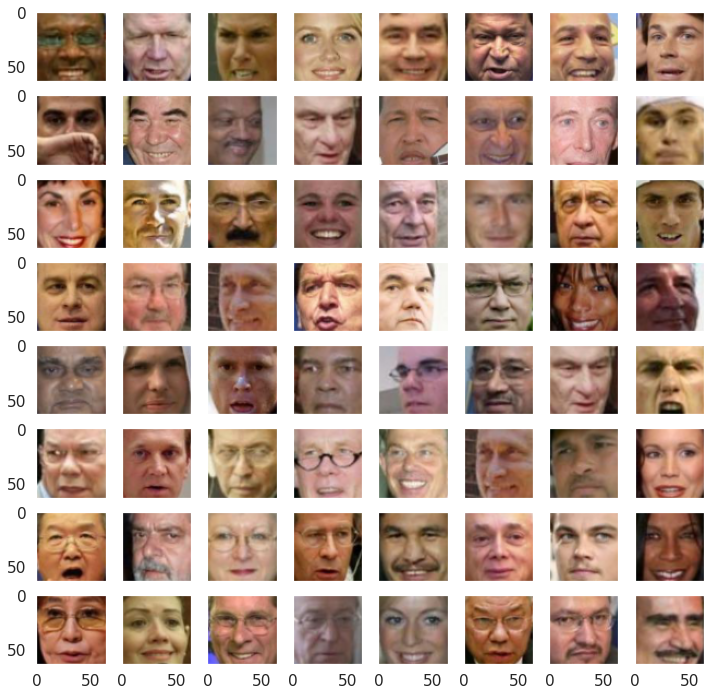

In [ ]:
print_images(train_dataset)

In [ ]:
print("Training input shape: ", data_train.shape)

Training input shape:  torch.Size([9200, 3, 64, 64])


## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy
latent_dim = 256

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
      super().__init__()
      self.flatten = nn.Flatten()
      self.encoder = nn.Sequential(

          # in: 3 x 64 x 64 

          nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),

          # out: 128 x 64 x 64

          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),

          # out:  256 x 32 x 32

          nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True),

          # out: 16 x 16 x 512

          # nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
          # nn.BatchNorm2d(512),
          # nn.LeakyReLU(0.2, inplace=True),

          # # out: 8 x 8 x 512

      )
      
      self.in_latent = nn.Sequential(
          nn.Linear(16 * 16 * 512, latent_dim),
          nn.BatchNorm1d(latent_dim),
          nn.ReLU(),

          # nn.Linear(8192, 512),
          # nn.BatchNorm1d(512),
          # nn.ReLU(),

          # nn.Linear(512, latent_size),
          # nn.BatchNorm1d(latent_size),
          # nn.ReLU()
      )

      self.out_latent = nn.Sequential(
          # nn.Linear(latent_size , 512),
          # nn.BatchNorm1d(512),
          # nn.ReLU(),

          # nn.Linear(512, 8192),
          # nn.BatchNorm1d(8192),
          # nn.ReLU(),

          nn.Linear(latent_dim, 16 * 16 * 512),
          nn.BatchNorm1d(16 * 16 * 512),
          nn.ReLU(),
          nn.Unflatten(1, (512, 16, 16))
      )

      self.decoder = nn.Sequential(

        # in: 16 x 16 x 512

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
          
        # out: 32 x 32 x 256 

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        
        # out: 128 x 64 x 64

        nn.ConvTranspose2d(128, 3, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(3),
        nn.Sigmoid()

        # in: 64 x 64 x 3
        )
              
    def forward(self, x):
      x = self.encoder(x)
      x = torch.reshape(x, (-1, 16 * 16 * 512))
      latent_code = self.in_latent(x)
      x = self.out_latent(latent_code)
      reconstruction = self.decoder(x)
      return reconstruction, latent_code

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [13]:
MAX_EPOCHS = 10

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!nvidia-smi

Sat Dec 17 09:15:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, model_name='', load=False):
# def train(model, opt, sched, loss_fn, epochs, data_tr, data_val, model_name='', load=False): 
    torch.cuda.empty_cache()
    gc.collect()

    # загрузка модели
    PATH = './'
    EXTENSION = '.pth'
    if (model_name != '' and load == True):
        model = torch.load(PATH + model_name + '.pth')
        model.to(device)
    
    # X_val, Y_val = next(iter(data_val))
    
    train_losses = []
    valid_losses = []
    metric_scores = []
    best_metric_score = 0
    
    for epoch in range(epochs):
        
        #train phase
        
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        model.train()
        running_train_losses = []
        for X_train_batch in data_tr:
            # data to device
            X_train_batch = X_train_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # функции подсчета средних лоссов пришлось изменить,
            # потому что изначально они работали неправильно 
            with torch.set_grad_enabled(True):
                # forward
                reconstructions, latent_code = model(X_train_batch)

                loss =  loss_fn(X_train_batch, reconstructions) # forward-pass
                running_train_losses.append(loss.detach().item())
                loss.backward()   # backward-pass
                opt.step()  # update weights

            avg_train_loss = np.mean(running_train_losses)
            
        # train loss    
        epoch_train_loss = avg_train_loss
        train_losses.append(epoch_train_loss)
        toc = time()
        print('finished train phase;', end=' ')


        # show intermediate results
        
        # test phase
        model.eval() 
        running_val_losses = []
        for X_val_batch in data_val:
            # print(X_val_batch.shape)
            with torch.no_grad():
                reconstructions, latent_code = model(X_val_batch.to(device)) # detach and put into cpu
                loss = loss_fn(X_val_batch.to(device), reconstructions) # forward-pass
                running_val_losses.append(loss.detach().item())
                
            avg_val_loss = np.mean(running_val_losses)
            
        # val loss    
        epoch_val_loss = avg_val_loss
        valid_losses.append(epoch_val_loss)
        toc = time()
        print('finished valid phase;', end=' ')

        # Visualize tools
        fig0 = plt.figure("Figure 0", figsize=(15,9))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val_batch[k].cpu().permute(1, 2, 0))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(reconstructions[k].detach().cpu().permute(1, 2, 0))
            plt.title('Output')
            plt.axis('off')

        first_suptitle = ('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, epochs, epoch_train_loss, avg_val_loss))
        plt.suptitle(f'{first_suptitle}')

        fig1 = plt.figure("Figure 1")
        plt.plot(train_losses, label="train loss")
        plt.plot(valid_losses, label="valid loss")

        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title('Losses')
        fig1.set_figheight(5)
        fig1.set_figwidth(15)
        
        plt.show()
    
    if model_name == '':
        model_name = f'{model=}'.split('=')[0]
    
    torch.save(model, PATH + 
           f'{model_name}_epochs-{epochs}_{datetime.now().isoformat(sep="_", timespec="seconds").replace(":", "-")}'
           + EXTENSION
          )
    
    
    return model, model_name, [train_losses, valid_losses]

In [11]:
def predict_and_show(model, data_val, loss_fn):
  model.eval() 
  running_val_losses = []
  for X_val_batch in data_val:
      with torch.no_grad():
          reconstructions, latent_code = model(X_val_batch.to(device)) # detach and put into cpu
      break
      
  fig0 = plt.figure("Figure 0", figsize=(15,9))
  clear_output(wait=True)
  for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(X_val_batch[k].cpu().permute(1, 2, 0))
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(reconstructions[k].detach().cpu().permute(1, 2, 0))
      plt.title('Output')
      plt.axis('off')
  
  plt.show()


def show_results(results, nrow, ncol):
  fig, ax = plt.subplots(nrows=nrow, ncols=ncol,figsize=(12, 12))
  plt.axis('off')

  for i, fig_x in enumerate(ax.flatten()):
      im_val = results[i].detach().cpu().permute(1, 2, 0)
      imshow(im_val, plt_ax=fig_x)

def get_latent_vectors(model, data_tr):
  model.eval() 
  latent_codes_array = []
  running_val_losses = []
  for X_val_batch in data_tr:
      with torch.no_grad():
          _, latent_code = model(X_val_batch.to(device)) # detach and put into cpu
          latent_codes_array.append(latent_code)
  return latent_codes_array


def print_data_images(data, indexes=None, title='', rows=2, cols=5):
  fig, ax = plt.subplots(nrows=rows, ncols=cols,figsize=(12, 4), \
                          sharey=True, sharex=True)
  plt.title(title)

  if (hasattr(data, 'requires_grad')):
    if (data.requires_grad):
      data = data.detach().cpu()

  if (data[0].shape[2] != 3):
      data = data.permute(0, 2, 3, 1)

  for i, fig_x in enumerate(ax.flatten()):
      if (indexes != None):
        im_val = torch.Tensor(data[indexes[i]])
      else:
        im_val = torch.Tensor(data[i])
      imshow(im_val, plt_ax=fig_x)

def calculate_latent_mean(model, data, encoder_dim=(-1, 16 * 16 * 512)):
  output = torch.reshape(model.encoder(data), encoder_dim)
  latent_code = model.in_latent(output)
  mean = torch.mean(latent_code.to('cpu'))
  return latent_code, mean

def Id_do_anything_to_make_you_smile(model, smile_mean, sad_mean, latent_sad):
  smile = smile_mean - sad_mean
  latent_sad += smile
  out_latent = model.out_latent(latent_sad)
  smiled = model.decoder(out_latent)
  return smiled

def change_attribute(model, data, df_attrs, attribute, second_attribute=None, change_second=True):
  if (second_attribute == None):
    one_indexes = list(df_attrs[[attribute]].sort_values([attribute]).tail(15).index)
    two_indexes = list(df_attrs[[attribute]].sort_values([attribute]).head(15).index)
  else:
    one_indexes = list(df_attrs[[attribute]].sort_values([attribute]).tail(15).index)
    two_indexes = list(df_attrs[[second_attribute]].sort_values([second_attribute]).tail(15).index)

  one_data = torch.FloatTensor(data[one_indexes]).permute(0, 3, 1, 2).to(device)
  two_data = torch.FloatTensor(data[two_indexes]).permute(0, 3, 1, 2).to(device)

  latent_one, latent_one_mean = calculate_latent_mean(model, one_data)
  latent_two, latent_two_mean = calculate_latent_mean(model, two_data)

  if change_second:
    changed_data = Id_do_anything_to_make_you_smile(model, latent_one_mean, latent_two_mean, latent_two)
  else:
    changed_data = Id_do_anything_to_make_you_smile(model, latent_two_mean, latent_one_mean, latent_one)

  return one_indexes, two_indexes, one_data, two_data, latent_one, latent_two, changed_data
  

In [ ]:
def likelihood_loss(x, reconstruction):
    # """
    # часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    # """
    loss = nn.MSELoss()
    return loss(reconstruction, x)

In [ ]:
# если уже модель существует, удалим ее, чтобы освободить память
if 'autoencoder' in globals():
    del autoencoder, optimizer#, scheduler
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
autoencoder = Autoencoder().to(device)

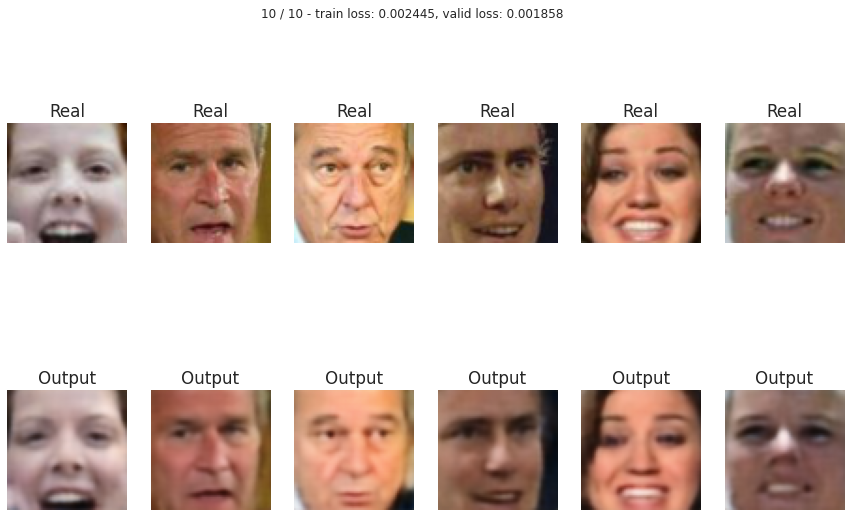

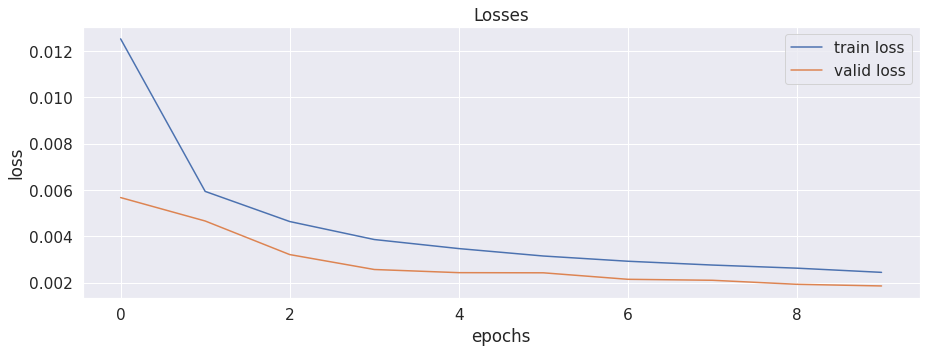

In [ ]:
MAX_EPOCHS = 10
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

autoencoder_model, autoencoder_model_name, autoencoder_losses_history = train(autoencoder, optimizer, likelihood_loss, 
                                                    MAX_EPOCHS, train_dataloader, val_dataloader, model_name='autoencoder')

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

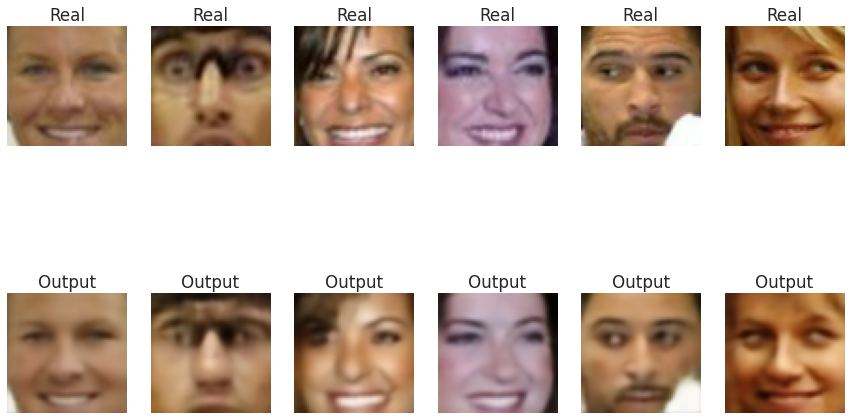

In [ ]:
# первые 6 картинок
predict_and_show(autoencoder, val_dataloader, likelihood_loss)

Not bad, right? 

Right

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
rand_vec = torch.Tensor(np.random.randn(25, latent_dim))

In [ ]:
# output = autoencoder.in_latent(rand_vec.to(device))
output = autoencoder.out_latent(rand_vec.to(device))
output = autoencoder.decoder(output.to(device))

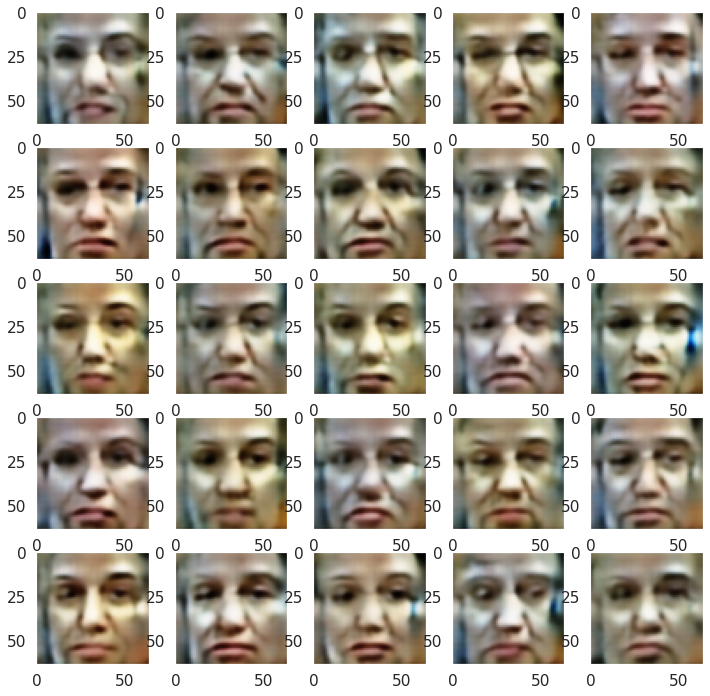

In [ ]:
show_results(output, 5, 5)

In [ ]:
# # show_results(output, 5, 5)
# latent_spaces = get_latent_vectors(autoencoder, train_dataloader)
# latent_spaces = torch.squeeze(torch.stack(list(latent_spaces), dim=0))

In [ ]:
# # latent_spaces.detach().cpu()
# mu = torch.mean(latent_spaces.detach().cpu(), (0, 1))
# sigma = torch.std(latent_spaces.detach().cpu(), (0, 1))

# rv = np.array([sigma * np.random.normal(0, 1, 256) + mu for i in range(25)])

In [ ]:
# a=np.vstack(rv).astype(np.float)
# b = torch.from_numpy(a)

# output_dist = autoencoder.out_latent(torch.Tensor(b).to(device))
# output_dist = autoencoder.decoder(torch.Tensor(b).to(device))

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smiling_indexes, sad_indexes, smiling_data, sad_data, latent_smile, latent_sad, smiled_data = change_attribute(autoencoder, data, attrs, 'Smiling', change_second=True)

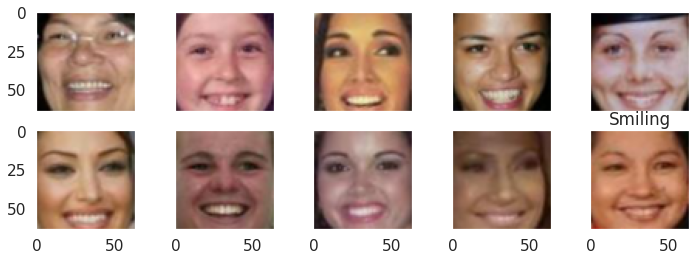

In [ ]:
# выведем изображения с улыбками
print_data_images(data, smiling_indexes, 'Smiling')

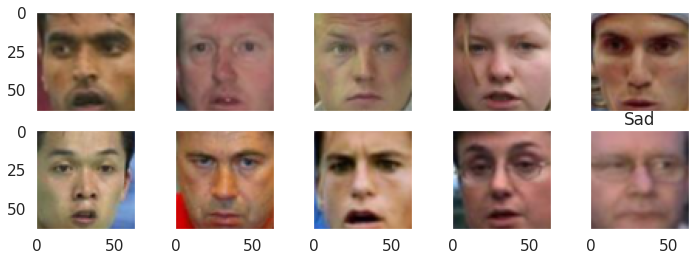

In [ ]:
# выведем изображения с грустью
print_data_images(data, sad_indexes, 'Sad')

**БЫЛО**

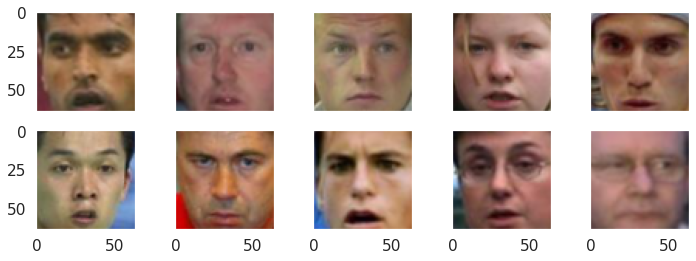

In [ ]:
print_data_images(data, sad_indexes, rows=2, cols=5)

**СТАЛО**

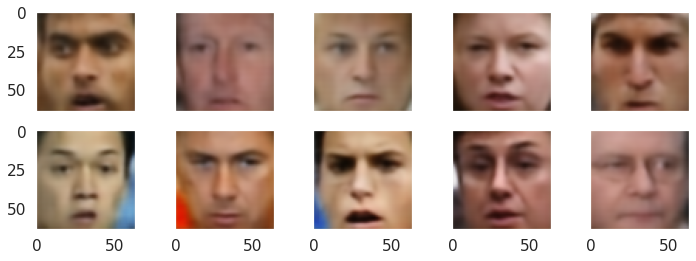

In [ ]:
print_data_images(smiled_data, rows=2, cols=5)

*больше похоже, что они не стали радостными, а перестали быть грустными/недовольными*

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [ ]:
first_attribute = 'Big Lips'
second_attribute = None

In [ ]:
indexes1, indexes2, data1, data2, latent1, latent2, changed_data = change_attribute(autoencoder, data, attrs, first_attribute, second_attribute, change_second=True)

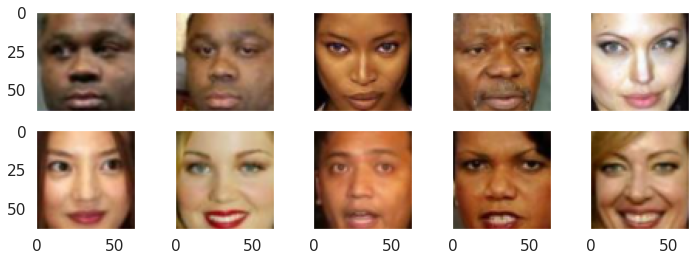

In [ ]:
print_data_images(data, indexes1, rows=2, cols=5)

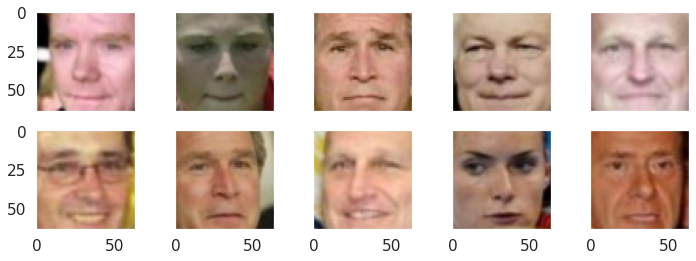

In [ ]:
print_data_images(data, indexes2, rows=2, cols=5)

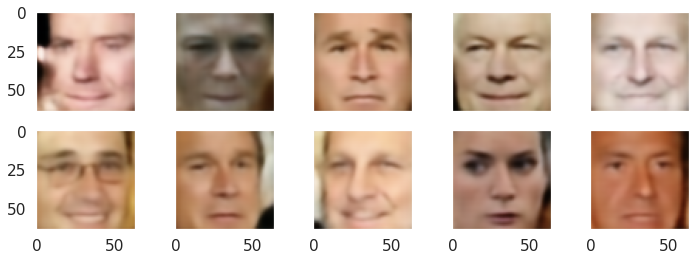

In [ ]:
print_data_images(changed_data, rows=2, cols=5)

Вывод в случае с признаком "Большие губы" изменений вообще почти нет, картинка тоьлко стала размыта

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 16
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
val_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# train_dataset.data = torch.unsqueeze(train_dataset.data, dim=1)
# val_dataset.data = torch.unsqueeze(val_dataset.data, dim=1)

# train_dataset.data = torch.Tensor(train_dataset.data)
# val_dataset.data = torch.Tensor(val_dataset.data)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [13]:
# изменим размер латентного пространства
latent_dim=256

class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(

          # in: 1 x 28 x 28 

          nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),

          # out: 128 x 28 x 28

          nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),

          # out: 128 x 14 x 14

          nn.Conv2d(128, 512, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True),

          # out:  512 x 7 x 7
      )
        
        self.in_latent = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Linear(2048, latent_dim * 2),
            # nn.BatchNorm1d(latent_dim * 2),
            # nn.ReLU()
        )

        self.out_latent = nn.Sequential(
            nn.Linear(latent_dim , 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Linear(2048, 512 * 7 * 7),
            nn.BatchNorm1d(512 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (512, 7, 7))
        )

        self.decoder = nn.Sequential(

          # in: 512 x 7 x 7

          nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
            
          # out: 128 x 14 x 14 

          nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
          
          # out: 128 x 28 x 28

          nn.ConvTranspose2d(128, 1, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(1),
          nn.Sigmoid()

          # in: 1 x 28 x 28
          )

    def encode(self, x):
      x = self.encoder(x)
      x = torch.reshape(x, (-1, 512 * 7 * 7))
      x = self.in_latent(x)

      x = x.view(x.shape[0], 2, -1)
      mu = x[:, 0, :]
      logsigma = x[:, 1, :]

      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            z = mu + (eps * std)   
            z = z.to(device)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        z = self.out_latent(z)
        reconstruction = self.decoder(z)     
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [16]:
def KL_divergence(mu, logvar):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [15]:
# та же функция но из дата лоудера берем не только батч, но и метку
def train_labeled(model, opt, loss_fn, epochs, data_tr, data_val, model_name='', load=False): 
    torch.cuda.empty_cache()
    gc.collect()

    PATH = './'
    EXTENSION = '.pth'
    if (model_name != '' and load == True):
        model = torch.load(PATH + model_name + '.pth')
        model.to(device)
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        model.train()
        running_train_losses = []
        for X_train_batch, label in data_tr:
            X_train_batch = X_train_batch.to(device)
            opt.zero_grad()
            with torch.set_grad_enabled(True):
                mu, logsigma, reconstructions = model(X_train_batch)
                loss =  loss_fn(X_train_batch, mu, logsigma, reconstructions) 
                running_train_losses.append(loss.detach().item())
                loss.backward() 
                opt.step()
            avg_train_loss = np.mean(running_train_losses)
        epoch_train_loss = avg_train_loss
        train_losses.append(epoch_train_loss)
        toc = time()
        print('finished train phase;', end=' ')

        model.eval() 
        running_val_losses = []
        for X_val_batch, label in data_val:
            with torch.no_grad():
                mu, logsigma, reconstructions = model(X_val_batch.to(device)) 
                loss = loss_fn(X_val_batch.to(device), mu, logsigma, reconstructions)
                running_val_losses.append(loss.detach().item())
                
            avg_val_loss = np.mean(running_val_losses)

        epoch_val_loss = avg_val_loss
        valid_losses.append(epoch_val_loss)
        toc = time()
        print('finished valid phase;', end=' ')
        
        fig0 = plt.figure("Figure 0", figsize=(15,9))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val_batch[k][0].detach().cpu().numpy())
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(reconstructions[k][0].detach().cpu().numpy())
            plt.title('Output')
            plt.axis('off')

        first_suptitle = ('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, epochs, epoch_train_loss, avg_val_loss))
        plt.suptitle(f'{first_suptitle}')

        fig1 = plt.figure("Figure 1")
        plt.plot(train_losses, label="train loss")
        plt.plot(valid_losses, label="valid loss")

        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title('Losses')
        fig1.set_figheight(5)
        fig1.set_figwidth(15)
        
        plt.show()
    
    if model_name == '':
        model_name = f'{model=}'.split('=')[0]
    
    torch.save(model, PATH + 
           f'{model_name}_epochs-{epochs}_{datetime.now().isoformat(sep="_", timespec="seconds").replace(":", "-")}'
           + EXTENSION
          )
    
    
    return model, model_name, [train_losses, valid_losses]

def predict_and_show_labled(model, data_val, loss_fn):
  model.eval() 
  running_val_losses = []
  for X_val_batch, label in data_val:
      with torch.no_grad():
          mu, logsigma, reconstructions = model(X_val_batch.to(device)) # detach and put into cpu
      break
      
  fig0 = plt.figure("Figure 0", figsize=(15,9))
  clear_output(wait=True)
  for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(X_val_batch[k][0].detach().cpu())
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(reconstructions[k][0].detach().cpu())
      plt.title('Output')
      plt.axis('off')
  
  plt.show()

def show_results(results, nrow, ncol):
  fig, ax = plt.subplots(nrows=nrow, ncols=ncol,figsize=(12, 12))
  plt.axis('off')

  for i, fig_x in enumerate(ax.flatten()):
      im_val = results[i].detach().cpu()
      imshow(im_val[0], plt_ax=fig_x)

def get_latent_vectors(model, data_tr):
  model.eval() 
  latent_codes_array = []
  running_val_losses = []
  for X_val_batch in data_tr:
      with torch.no_grad():
          _, latent_code = model(X_val_batch.to(device)) # detach and put into cpu
          latent_codes_array.append(latent_code)
  return latent_codes_array

def prepare_tsne_data(model, data_val):
    means = torch.Tensor()
    labels = torch.Tensor()
    with torch.no_grad():
        for X_val_batch, label in data_val:
          reconstruction, mu, logsigma = model(X_val_batch.to(device))
          means = torch.cat((means, mu.detach().cpu()), 0)
          labels = torch.cat((labels, label), dim=0)
    return means, labels

In [ ]:
# если уже модель существует, удалим ее, чтобы освободить память
if 'vae' in globals():
    del vae, optimizer
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
# # если выпадает ошибка cudNNN
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

vae = VAE().to(device)

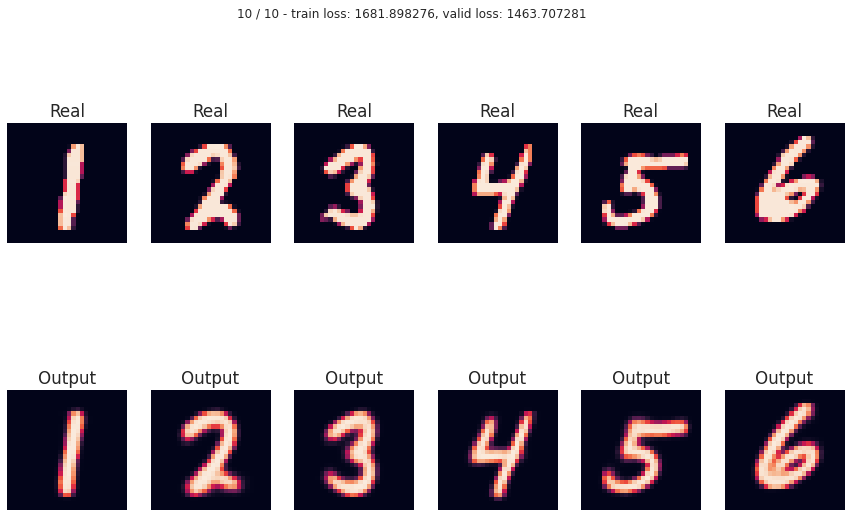

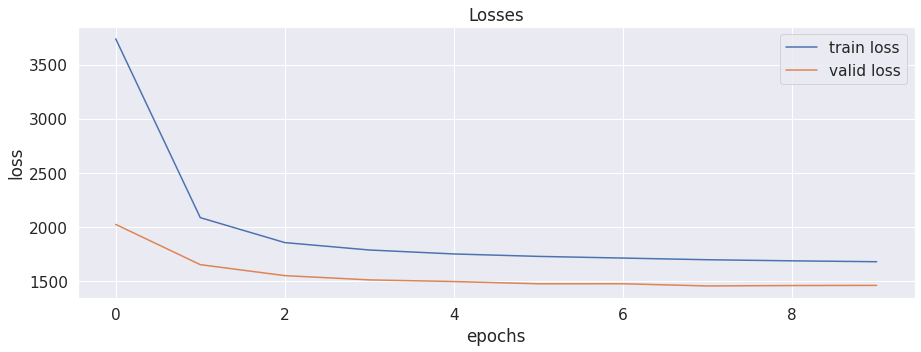

In [ ]:
MAX_EPOCHS = 10
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

vae_model, vae_model_name, vae_losses_history = train_labeled(vae, optimizer, loss_vae, 
                                                    MAX_EPOCHS, train_loader, val_loader, model_name='VAE')

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

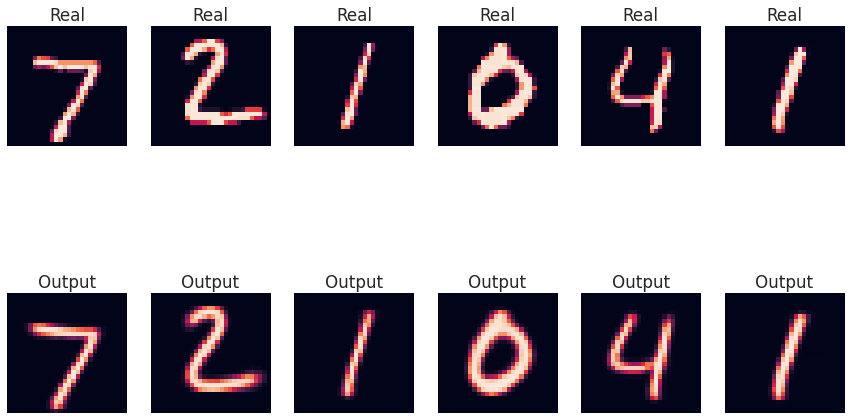

In [ ]:
# первые 6 картинок
predict_and_show_labled(vae, val_loader, loss_vae)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# сгенерируем 16 рандомных векторов размера latent_dim
rand_vec = torch.Tensor(np.array([np.random.normal(0, 1, latent_dim) for i in range(16)]))
output = vae.out_latent(rand_vec.to(device))
output = vae.decoder(output.to(device))

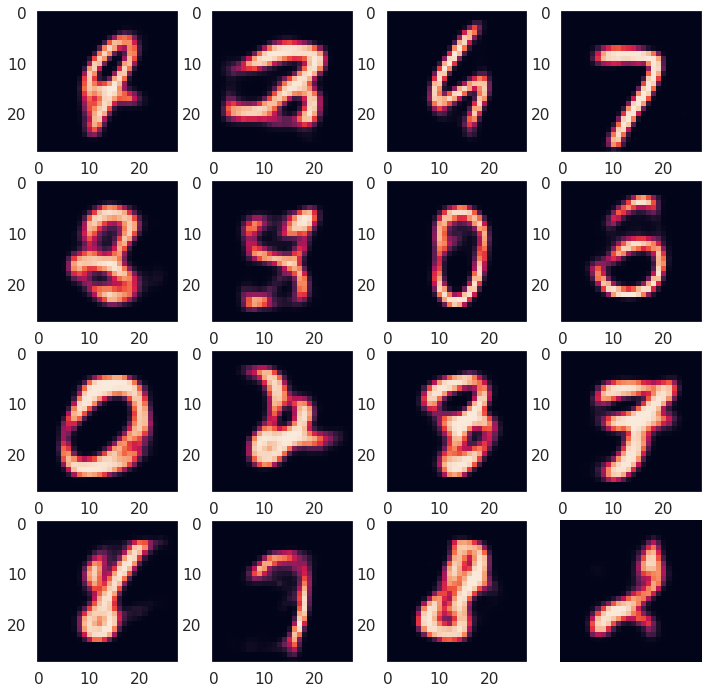

In [ ]:
show_results(output, 4, 4)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
means, labels = prepare_tsne_data(vae, val_loader)

In [ ]:
labels = labels.view(-1, 1)
tsne_date = TSNE(n_components=2, random_state=42).fit_transform(means)
tsne_date = torch.Tensor(tsne_date)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


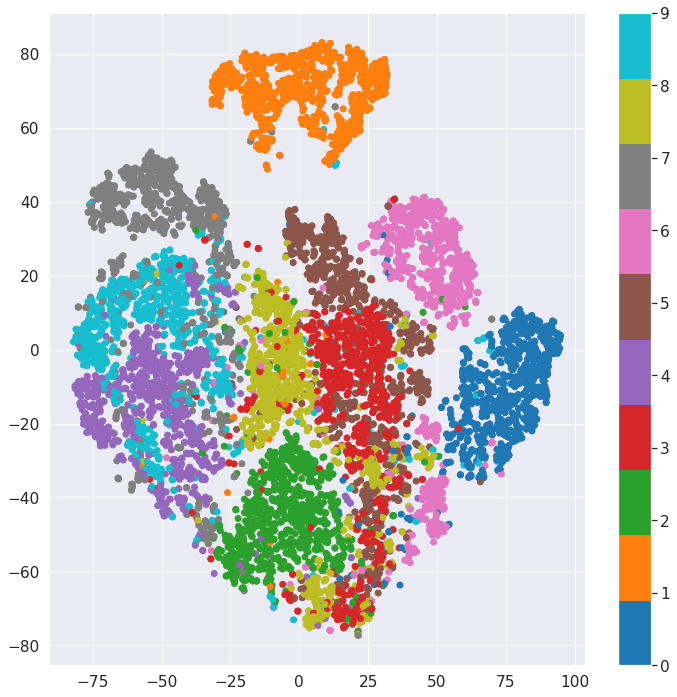

In [ ]:
plt.subplots(figsize=(12, 12))
plt.scatter(tsne_date[:, 0], tsne_date[:, 1], c=labels, cmap='tab10')
plt.colorbar()

Что вы думаете о виде латентного представления?

Классы объектов плохо разделены, за исключением 1 и 7 - они дальше от всех остальных, скорее всего, потому что  в них отсутствуют дугообразные элементы при написании

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
latent_dim=256
# число классов 
nclasses = 10

class CVAE(nn.Module):
    def __init__(self, latent_dim=256):
      super(CVAE, self).__init__()
      
      self.flatten = nn.Flatten()

      #encoder
      self.encoder = nn.Sequential(
          
          # in: 1 x 28 x 28 

          nn.Conv2d(1 + nclasses, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),

          # out: 128 x 28 x 28

          nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),

          # out: 128 x 14 x 14

          nn.Conv2d(128, 512, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True),

          # out:  512 x 7 x 7

          nn.Flatten(),

          nn.Linear(512 * 7 * 7, 2048),
          nn.BatchNorm1d(2048),
          nn.ReLU(),

          nn.Linear(2048, latent_dim * 2),

          )
 
      # decoder 
      self.decoder = nn.Sequential(
          
          nn.Linear(latent_dim + nclasses, 2048),
          nn.BatchNorm1d(2048),
          nn.ReLU(),

          nn.Linear(2048, 512 * 7 * 7),
          nn.BatchNorm1d(512 * 7 * 7),
          nn.ReLU(),
          nn.Unflatten(1, (512, 7, 7)),

          # in: 512 x 7 x 7

          nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
            
          # out: 128 x 14 x 14 

          nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
          
          # out: 128 x 28 x 28

          nn.ConvTranspose2d(128, 1, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(1),
          nn.Sigmoid()

          # in: 1 x 28 x 28

          )

    def encode(self, x, class_num):
        class_num = class_num.unsqueeze(2).unsqueeze(3).expand(-1, -1, 28, 28)
        x = torch.cat([x, class_num], dim=1)
        x = self.encoder(x).view(x.shape[0], 2, -1)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]     
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            z = mu + (eps * std)   
            z = z.to(device)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        z = torch.cat((z, class_num), dim=1) 
        reconstruction = self.decoder(z)     
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)

        return mu, logsigma, reconstruction

In [ ]:
def train_labeled_with_labels(model, opt, loss_fn, epochs, data_tr, data_val, one_hot_encoder, model_name='', load=False): 
    torch.cuda.empty_cache()
    gc.collect()

    PATH = './'
    EXTENSION = '.pth'
    if (model_name != '' and load == True):
        model = torch.load(PATH + model_name + '.pth')
        model.to(device)
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        model.train()
        running_train_losses = []
        for X_train_batch, label in data_tr:
            label = one_hot_encoder.transform(np.array(label).reshape(-1, 1))
            label = torch.Tensor(label).to(device)
            X_train_batch = X_train_batch.to(device)
            opt.zero_grad()
            with torch.set_grad_enabled(True):
                mu, logsigma, reconstructions = model(X_train_batch, label)
                loss =  loss_fn(X_train_batch, mu, logsigma, reconstructions) 
                running_train_losses.append(loss.detach().item())
                loss.backward() 
                opt.step()
            avg_train_loss = np.mean(running_train_losses)
        epoch_train_loss = avg_train_loss
        train_losses.append(epoch_train_loss)
        toc = time()
        print('finished train phase;', end=' ')

        model.eval() 
        running_val_losses = []
        for X_val_batch, label in data_val:
            label = one_hot_encoder.transform(np.array(label).reshape(-1, 1))
            label = torch.Tensor(label).to(device)
            X_val_batch = X_val_batch.to(device)
            with torch.no_grad():
                mu, logsigma, reconstructions = model(X_val_batch, label) 
                loss = loss_fn(X_val_batch.to(device), mu, logsigma, reconstructions)
                running_val_losses.append(loss.detach().item())
                
            avg_val_loss = np.mean(running_val_losses)

        epoch_val_loss = avg_val_loss
        valid_losses.append(epoch_val_loss)
        toc = time()
        print('finished valid phase;', end=' ')
        
        fig0 = plt.figure("Figure 0", figsize=(15,9))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val_batch[k][0].detach().cpu().numpy())
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(reconstructions[k][0].detach().cpu().numpy())
            plt.title('Output')
            plt.axis('off')

        first_suptitle = ('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, epochs, epoch_train_loss, avg_val_loss))
        plt.suptitle(f'{first_suptitle}')

        fig1 = plt.figure("Figure 1")
        plt.plot(train_losses, label="train loss")
        plt.plot(valid_losses, label="valid loss")

        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title('Losses')
        fig1.set_figheight(5)
        fig1.set_figwidth(15)
        
        plt.show()
    
    if model_name == '':
        model_name = f'{model=}'.split('=')[0]
    
    torch.save(model, PATH + 
           f'{model_name}_epochs-{epochs}_{datetime.now().isoformat(sep="_", timespec="seconds").replace(":", "-")}'
           + EXTENSION
          )
    
    
    return model, model_name, [train_losses, valid_losses]

def predict_and_show_labled(model, data_val, loss_fn, one_hot_encoder):
  model.eval() 
  running_val_losses = []

  for X_val_batch, label in data_val:
      label = one_hot_encoder.transform(np.array(label).reshape(-1, 1))
      label = torch.Tensor(label).to(device)
      X_val_batch = X_val_batch.to(device)
      with torch.no_grad():
          mu, logsigma, reconstructions = model(X_val_batch, label)
      break
      
  fig0 = plt.figure("Figure 0", figsize=(15,9))
  clear_output(wait=True)
  for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(X_val_batch[k][0].detach().cpu())
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(reconstructions[k][0].detach().cpu())
      plt.title('Output')
      plt.axis('off')
  
  plt.show()

def get_all_classes_from_vector(model, vector, one_hot_encoder):
    restored_images = torch.Tensor()
    for label in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        label = one_hot_encoder.transform(np.array(label).reshape(-1, 1))
        label = torch.Tensor(label).to(device)
        with torch.no_grad():
              reconstruction = model.decode(vector.to(device), label)
              restored_images = torch.cat((restored_images, reconstruction.to('cpu')), 0)
    return restored_images

def get_one_classes_from_vectors(model, one_hot_encoder, label=8, nvectors = 9, latent_dim = 256):
    rand_vec = torch.Tensor(np.array([np.random.normal(0, 1, latent_dim) for i in range(nvectors)]))
    label_vec = np.array([label for i in range(nvectors)])
    class_vec = torch.Tensor(one_hot_encoder.transform(np.array(label_vec).reshape(-1, 1)))

    return cvae.decode(rand_vec.to(device), class_vec.to(device))

def show_results(results, nrow, ncol, labels=None):
  fig, ax = plt.subplots(nrows=nrow, ncols=ncol,figsize=(12, 12))
  plt.axis('off')

  for i, fig_x in enumerate(ax.flatten()):
      im_val = torch.squeeze(results[i].detach().cpu(), dim=0)
      imshow(im_val, plt_ax=fig_x, title=labels[i])
      fig_x.set_xticks([])
      fig_x.set_yticks([])

def prepare_tsne_data(model, data_val, one_hot_encoder):
    means = torch.Tensor()
    labels = torch.Tensor()
    for X_val_batch, label in data_val:
        label_enc = one_hot_encoder.transform(np.array(label).reshape(-1, 1))
        label_enc = torch.Tensor(label_enc).to(device)
        X_val_batch = X_val_batch.to(device)
        with torch.no_grad():
            reconstruction, mu, logsigma = model(X_val_batch, label_enc)
            means = torch.cat((means, mu.detach().cpu()), 0)
            labels = torch.cat((labels, label.detach().cpu()), dim=0)

    return means, labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).reshape(-1, 1))

OneHotEncoder(sparse=False)

In [ ]:
# если уже модель существует, удалим ее, чтобы освободить память
if 'cvae' in globals():
    del cvae, optimizer
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

cvae = CVAE().to(device)

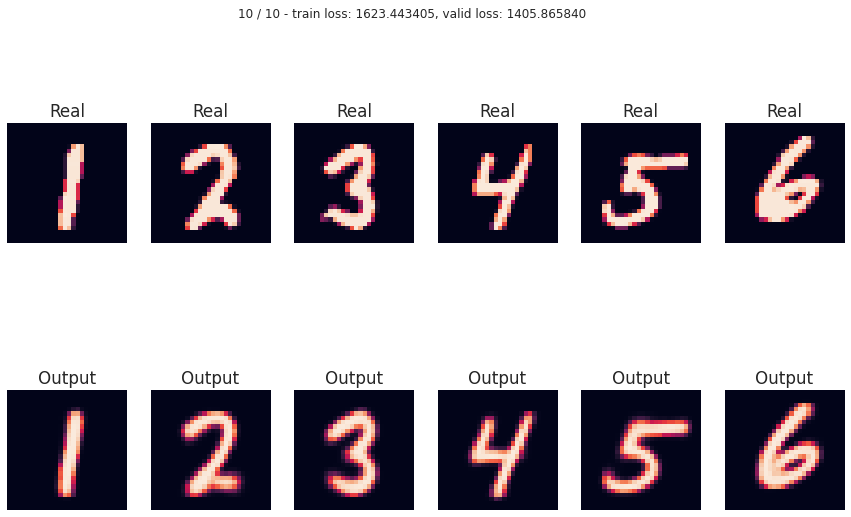

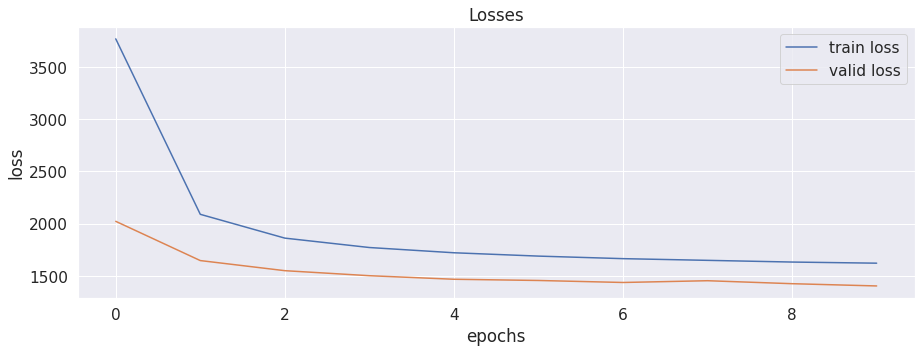

In [ ]:
MAX_EPOCHS = 10
optimizer = torch.optim.Adam(cvae.parameters(), lr=0.001)

cvae_model, cvae_model_name, cvae_losses_history = train_labeled_with_labels(cvae, optimizer, loss_vae, 
                                                    MAX_EPOCHS, train_loader, val_loader, one_hot_encoder, model_name='CVAE')

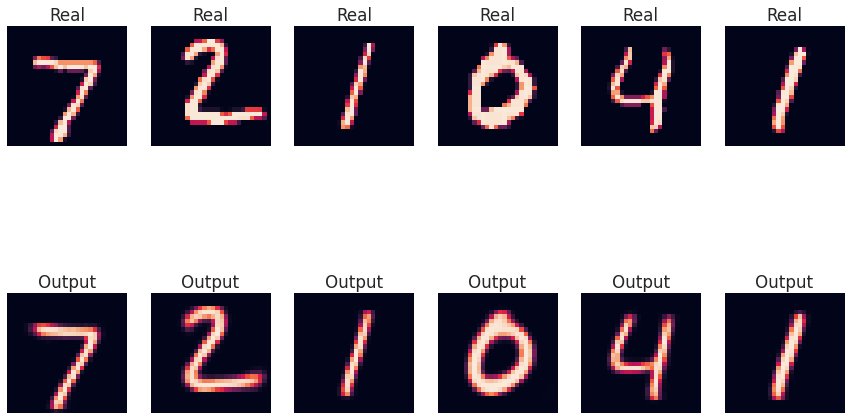

In [ ]:
# первые 6 картинок
predict_and_show_labled(cvae, val_loader, loss_vae, one_hot_encoder)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

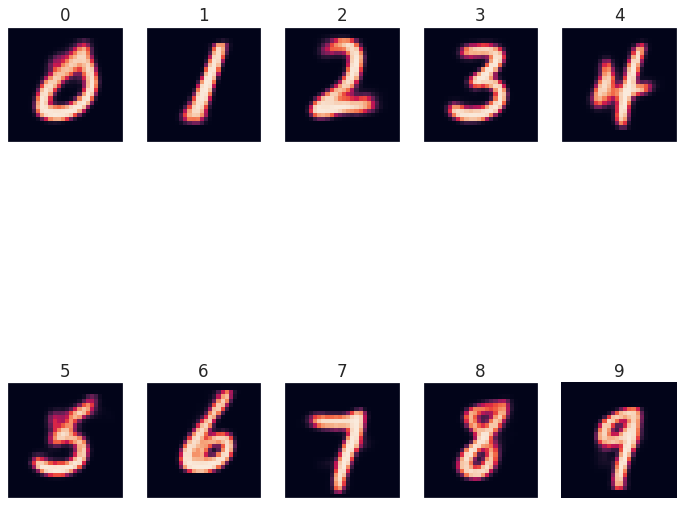

In [ ]:
# Один вектор ко всем числам
rand_vec = torch.Tensor(np.array([np.random.normal(0, 1, latent_dim) for i in range(1)]))
restored_images = get_all_classes_from_vector(cvae, rand_vec, one_hot_encoder)

show_results(restored_images, 2, 5, labels = [str(x) for x in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

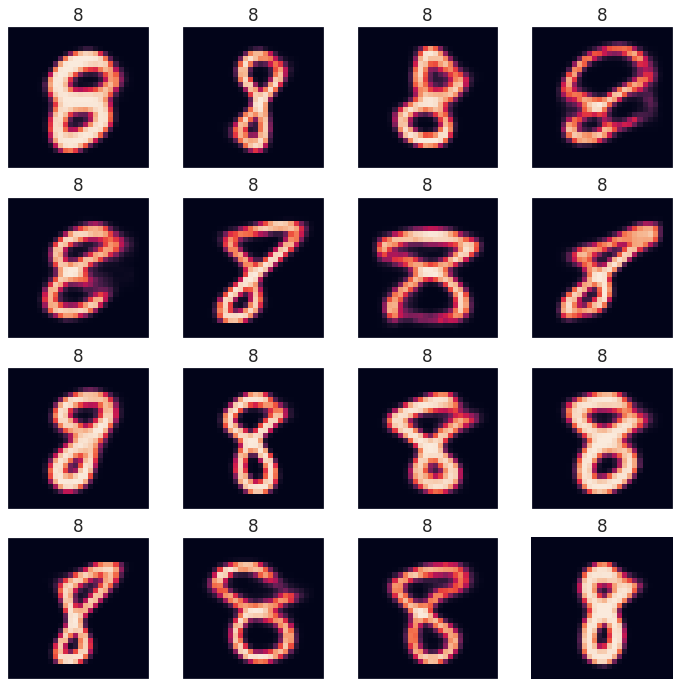

In [ ]:
# Разные векторы к одному числу
label = 8
nvectors = 16
restored_images = get_one_classes_from_vectors(cvae, one_hot_encoder, label, nvectors)
show_results(restored_images, 4, 4, labels = [str(x) for x in [label for i in range (nvectors)]])

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
means, labels = prepare_tsne_data(cvae, val_loader, one_hot_encoder)

In [ ]:
labels = labels.view(-1, 1)
tsne_date = TSNE(n_components=2, random_state=42).fit_transform(means)
tsne_date = torch.Tensor(tsne_date)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


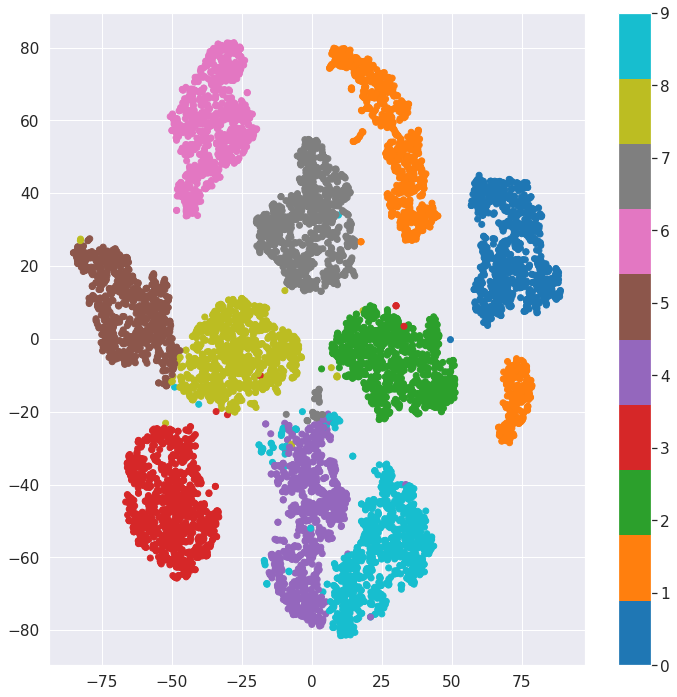

In [ ]:
plt.subplots(figsize=(12, 12))
plt.scatter(tsne_date[:, 0], tsne_date[:, 1], c=labels, cmap='tab10')
plt.colorbar()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Картинка выглядит лучше, многие похожие классы объектов(5 и 8) располежены рядом. Получается, CVAE работает...

Предлагаю посмотреть как это выглядит на трехмерном графике

In [ ]:
labels = labels.view(-1, 1)
tsne_date = TSNE(n_components=3, random_state=42).fit_transform(means)
tsne_date = torch.Tensor(tsne_date)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


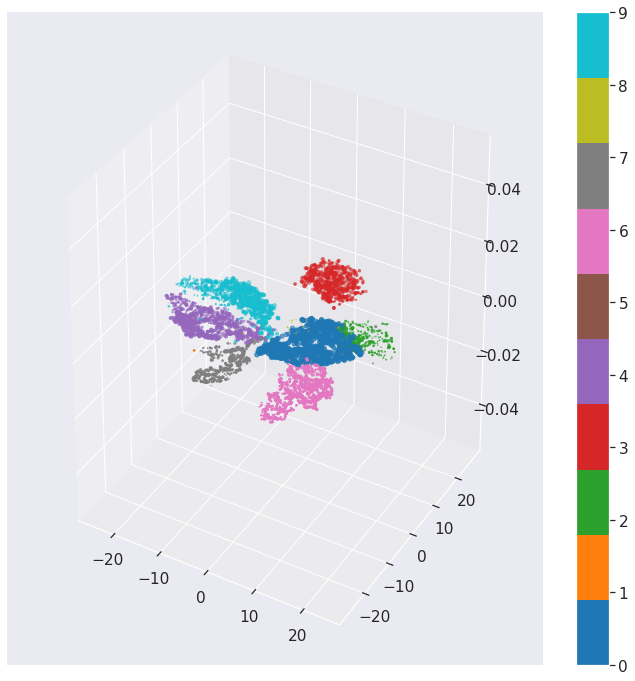

In [ ]:
plt.subplots(figsize=(12, 12))
plt.axes(projection ="3d")
plt.scatter(tsne_date[:, 0], tsne_date[:, 1], tsne_date[:, 2], c=labels, cmap='tab10')
plt.colorbar()

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
data, attrs = fetch_dataset()

In [ ]:
noise_factor = 0.5
data_noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 

data_train, data_val, attrs_train, attrs_val = train_test_split(data, attrs, train_size=0.7, random_state=42)
data_train = torch.Tensor(data_train).permute(0, 3, 1, 2)
data_val = torch.Tensor(data_val).permute(0, 3, 1, 2)

data_train_noisy, data_val_noisy, attrs_train_noisy, attrs_val_noisy = train_test_split(data_noisy, attrs, train_size=0.7, random_state=42)
data_train_noisy = torch.Tensor(data_train_noisy).permute(0, 3, 1, 2)
data_val_noisy = torch.Tensor(data_val_noisy).permute(0, 3, 1, 2)

In [ ]:
BATCH_SIZE = 16

train_dataset = TensorDataset(data_train)
val_dataset = TensorDataset(data_val)
train_dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False)

train_dataset_noisy = TensorDataset(data_train_noisy)
val_dataset_noisy = TensorDataset(data_val_noisy)
train_dataloader_noisy = DataLoader(data_train_noisy, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_noisy = DataLoader(data_val_noisy, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import warnings
warnings.filterwarnings("ignore")


107210

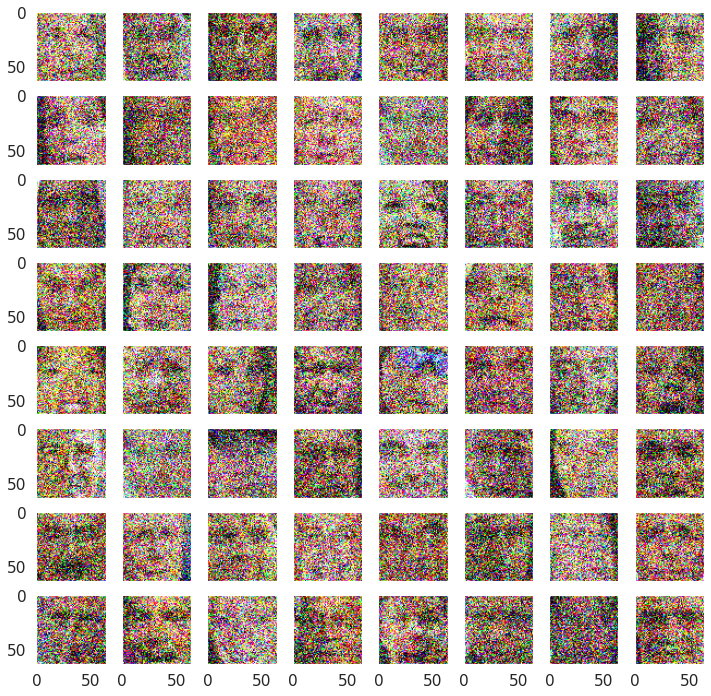

In [ ]:
print_images(train_dataset_noisy)

In [ ]:
def train_noisy(model, opt, loss_fn, epochs, data_tr_noisy, data_val_noisy, data_tr, data_val, model_name='', load=False):
# def train(model, opt, sched, loss_fn, epochs, data_tr, data_val, model_name='', load=False): 
    torch.cuda.empty_cache()
    gc.collect()

    # загрузка модели
    PATH = './'
    EXTENSION = '.pth'
    if (model_name != '' and load == True):
        model = torch.load(PATH + model_name + '.pth')
        model.to(device)
    
    # X_val, Y_val = next(iter(data_val))
    
    train_losses = []
    valid_losses = []
    metric_scores = []
    best_metric_score = 0
    
    for epoch in range(epochs):
        
        #train phase
        
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        model.train()
        running_train_losses = []
        for X_train_batch_noisy, X_train_batch in zip(data_tr_noisy, data_tr):
            # data to device
            X_train_batch_noisy = X_train_batch_noisy.to(device)
            X_train_batch = X_train_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # функции подсчета средних лоссов пришлось изменить,
            # потому что изначально они работали неправильно 
            with torch.set_grad_enabled(True):
                # forward
                reconstructions, latent_code = model(X_train_batch_noisy)

                loss =  loss_fn(X_train_batch, reconstructions) # forward-pass
                running_train_losses.append(loss.detach().item())
                loss.backward()   # backward-pass
                opt.step()  # update weights

            avg_train_loss = np.mean(running_train_losses)
            
        # train loss    
        epoch_train_loss = avg_train_loss
        train_losses.append(epoch_train_loss)
        toc = time()
        print('finished train phase;', end=' ')

        del reconstructions
        # show intermediate results
        
        # test phase
        model.eval() 
        running_val_losses = []
        for X_val_batch_noisy, X_val_batch in zip(data_val_noisy, data_val):
            with torch.no_grad():
                reconstructions1, latent_code = model(X_val_batch_noisy.to(device)) # detach and put into cpu
                loss = loss_fn(X_val_batch.to(device), reconstructions1) # forward-pass
                running_val_losses.append(loss.detach().item())
                
            avg_val_loss = np.mean(running_val_losses)
            
        # val loss    
        epoch_val_loss = avg_val_loss
        valid_losses.append(epoch_val_loss)
        toc = time()
        print('finished valid phase;', end=' ')
        # Visualize tools
        fig0 = plt.figure("Figure 0", figsize=(15,9))
        clear_output(wait=True)
        print(reconstructions1.shape)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(X_val_batch[k].cpu().permute(1, 2, 0))
            plt.title('Real')
            plt.axis('off')
          
            plt.subplot(3, 6, k+7)
            plt.imshow(X_val_batch_noisy[k].cpu().permute(1, 2, 0))
            plt.title('Noisy')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(reconstructions1[k].detach().cpu().permute(1, 2, 0))
            plt.title('Output')
            plt.axis('off')

        first_suptitle = ('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, epochs, epoch_train_loss, avg_val_loss))
        plt.suptitle(f'{first_suptitle}')

        fig1 = plt.figure("Figure 1")
        plt.plot(train_losses, label="train loss")
        plt.plot(valid_losses, label="valid loss")

        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title('Losses')
        fig1.set_figheight(5)
        fig1.set_figwidth(15)
        
        plt.show()
    
    if model_name == '':
        model_name = f'{model=}'.split('=')[0]
    
    torch.save(model, PATH + 
           f'{model_name}_epochs-{epochs}_{datetime.now().isoformat(sep="_", timespec="seconds").replace(":", "-")}'
           + EXTENSION
          )
    
    
    return model, model_name, [train_losses, valid_losses]

def likelihood_loss(x, reconstruction):
    # """
    # часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    # """
    loss = nn.MSELoss()
    return loss(reconstruction, x)

In [ ]:
# если уже модель существует, удалим ее, чтобы освободить память
if 'autoencoder_noisy' in globals():
    del autoencoder_noisy, optimizer#, scheduler
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
autoencoder_noisy = Autoencoder().to(device)

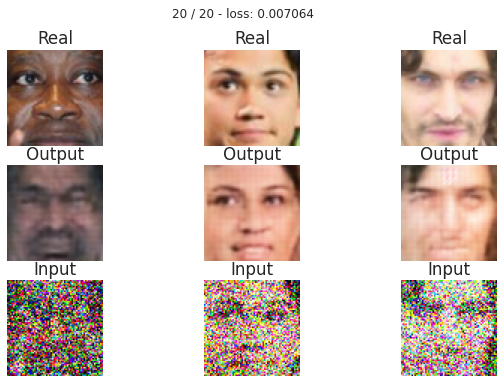

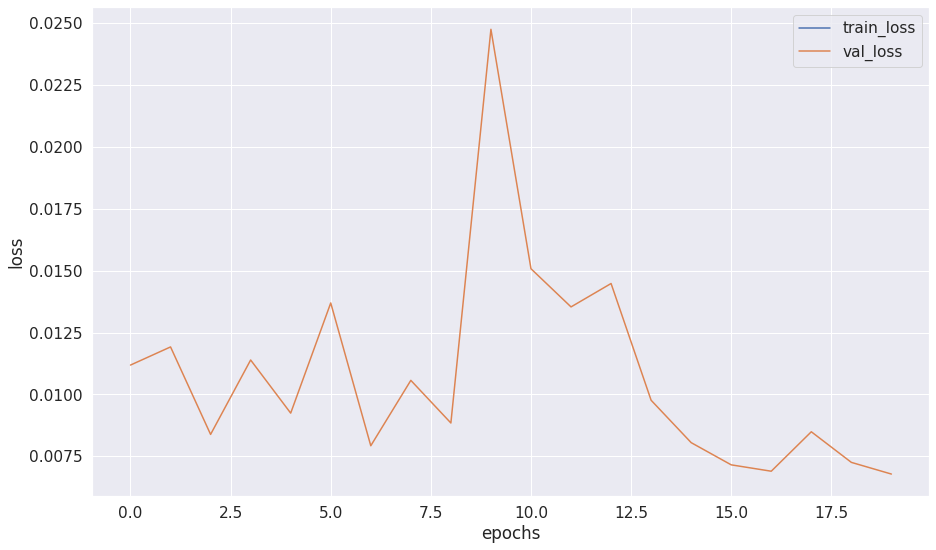

100%|██████████| 20/20 [21:39<00:00, 64.97s/it]


In [ ]:
MAX_EPOCHS = 10
optimizer = torch.optim.Adam(autoencoder_noisy.parameters(), lr=0.001)

autoencoder_noisy_model, autoencoder_noisy_model_name, autoencoder_noisy_losses_history = train_noisy(autoencoder_noisy, optimizer, likelihood_loss, 
                                                    MAX_EPOCHS, train_dataloader_noisy, val_dataloader_noisy, train_dataloader, val_dataloader, model_name='autoencoder_noisy')

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [7]:
# изменим размер латентного пространства
latent_dim=256

class FVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(FVAE, self).__init__()
        
        self.encoder = nn.Sequential(

          # in: 3 x 64 x 64 

          nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),

          # out: 128 x 64 x 64

          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),

          # out:  256 x 32 x 32

          nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True),

          # out: 16 x 16 x 512

        )
      
        self.in_latent = nn.Sequential(
            nn.Linear(16 * 16 * 512, latent_dim * 2),
            nn.BatchNorm1d(latent_dim * 2),
            nn.ReLU(),
        )

        self.out_latent = nn.Sequential(
            nn.Linear(latent_dim, 16 * 16 * 512),
            nn.BatchNorm1d(16 * 16 * 512),
            nn.ReLU(),
            nn.Unflatten(1, (512, 16, 16))
        )

        self.decoder = nn.Sequential(

          # in: 16 x 16 x 512

          nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(True),
            
          # out: 32 x 32 x 256 

          nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
          
          # out: 128 x 64 x 64

          nn.ConvTranspose2d(128, 3, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(3),
          nn.Sigmoid()

          # in: 64 x 64 x 3
          )

    def encode(self, x):
      x = self.encoder(x)
      x = torch.reshape(x, (-1, 512 * 16 * 16))
      x = self.in_latent(x)

      x = x.view(x.shape[0], 2, -1)
      mu = x[:, 0, :]
      logsigma = x[:, 1, :]

      return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            z = mu + (eps * std)   
            z = z.to(device)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        z = self.out_latent(z)
        reconstruction = self.decoder(z)     
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [8]:
# та же функция но из дата лоудера берем не только батч, но и метку
def train_vae_facial(model, opt, loss_fn, epochs, data_tr, data_val, model_name='', load=False): 
    torch.cuda.empty_cache()
    gc.collect()

    PATH = './'
    EXTENSION = '.pth'
    if (model_name != '' and load == True):
        model = torch.load(PATH + model_name + '.pth')
        model.to(device)
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        model.train()
        running_train_losses = []
        for X_train_batch in data_tr:
            X_train_batch = X_train_batch.to(device)
            opt.zero_grad()
            with torch.set_grad_enabled(True):
                mu, logsigma, reconstructions = model(X_train_batch)
                loss =  loss_fn(X_train_batch, mu, logsigma, reconstructions) 
                running_train_losses.append(loss.detach().item())
                loss.backward() 
                opt.step()
            avg_train_loss = np.mean(running_train_losses)
        epoch_train_loss = avg_train_loss
        train_losses.append(epoch_train_loss)
        toc = time()
        print('finished train phase;', end=' ')

        model.eval() 
        running_val_losses = []
        for X_val_batch in data_val:
            with torch.no_grad():
                mu, logsigma, reconstructions = model(X_val_batch.to(device)) 
                loss = loss_fn(X_val_batch.to(device), mu, logsigma, reconstructions)
                running_val_losses.append(loss.detach().item())
                
            avg_val_loss = np.mean(running_val_losses)

        epoch_val_loss = avg_val_loss
        valid_losses.append(epoch_val_loss)
        toc = time()
        print('finished valid phase;', end=' ')
        
        fig0 = plt.figure("Figure 0", figsize=(15,9))
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val_batch[k].detach().cpu().permute(1, 2, 0).numpy())
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(reconstructions[k].detach().cpu().permute(1, 2, 0).numpy())
            plt.title('Output')
            plt.axis('off')

        first_suptitle = ('%d / %d - train loss: %f, valid loss: %f' % (epoch+1, epochs, epoch_train_loss, avg_val_loss))
        plt.suptitle(f'{first_suptitle}')

        fig1 = plt.figure("Figure 1")
        plt.plot(train_losses, label="train loss")
        plt.plot(valid_losses, label="valid loss")

        plt.legend(loc='best')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title('Losses')
        fig1.set_figheight(5)
        fig1.set_figwidth(15)
        
        plt.show()
    
    if model_name == '':
        model_name = f'{model=}'.split('=')[0]
    
    torch.save(model, PATH + 
           f'{model_name}_epochs-{epochs}_{datetime.now().isoformat(sep="_", timespec="seconds").replace(":", "-")}'
           + EXTENSION
          )
    
    
    return model, model_name, [train_losses, valid_losses]

In [49]:
def get_latent_vectors(model, data_tr):
  model.eval() 
  latent_codes = torch.Tensor().to(device)
  for X_val_batch in data_tr:
      X_val_batch = X_val_batch.to(device)
      with torch.no_grad():
           mu, logsigma = model.encode(X_val_batch)
           z = model.gaussian_sampler(mu, logsigma)
           latent_codes = torch.cat([latent_codes, z], dim=0)
  return latent_codes

In [64]:
# если уже модель существует, удалим ее, чтобы освободить память
if 'fvae' in globals():
    del fvae, optimizer
    torch.cuda.empty_cache()
    gc.collect()

In [65]:
# # если выпадает ошибка cudNNN
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

fvae = FVAE().to(device)

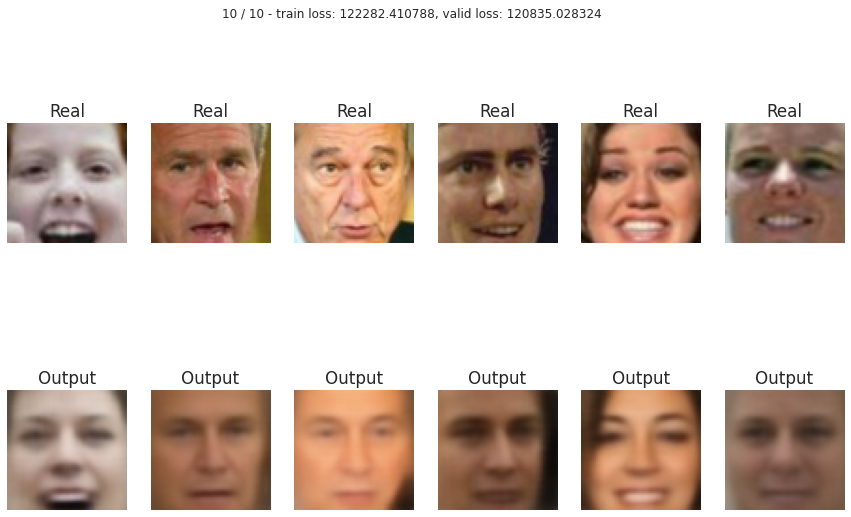

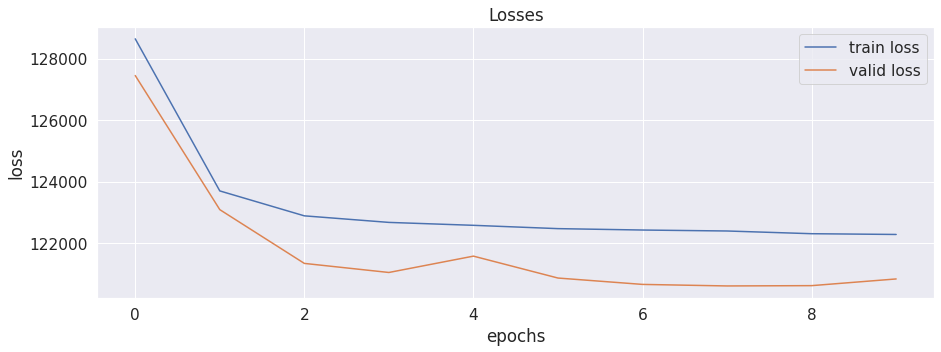

In [66]:
MAX_EPOCHS = 10
optimizer = torch.optim.Adam(fvae.parameters(), lr=0.001)

vae_model, vae_model_name, vae_losses_history = train_vae_facial(fvae, optimizer, loss_vae, 
                                                    MAX_EPOCHS, train_dataloader, val_dataloader, model_name='FVAE')

In [50]:
codes = get_latent_vectors(fvae, train_dataloader)

In [52]:
# обучаем LSHForest(его удалили - используем NearestNeighbors)
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(algorithm='ball_tree', leaf_size=30).fit(codes.to('cpu'))

In [53]:
def get_similar(model, data_tr, image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  model.eval()
  with torch.no_grad():
      image = image.view(1, 3, 64, 64)
      image = torch.tensor(image).to(device)
      mu, logsigma = model.encode(image)
      code = model.gaussian_sampler(mu, logsigma)
    
  (distances,),(idx,) = nbrs.kneighbors(code.detach().cpu().numpy(), n_neighbors=n_neighbors)

  return distances, data_tr[idx]

In [57]:
def show_similar(model, data_tr, image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(model, data_tr, image, n_neighbors=11)
    
    plt.figure(figsize=[15,15])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    plt.axis('Off')
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [61]:
rand_idx = random.randint(0, len(data_train))

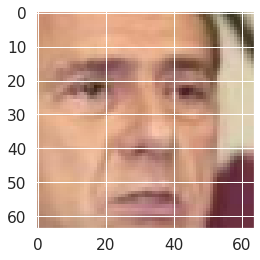

In [62]:
plt.imshow(data_train[rand_idx].permute(1, 2, 0))

<ipython-input-53-5d600ba97ab5>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).to(device)


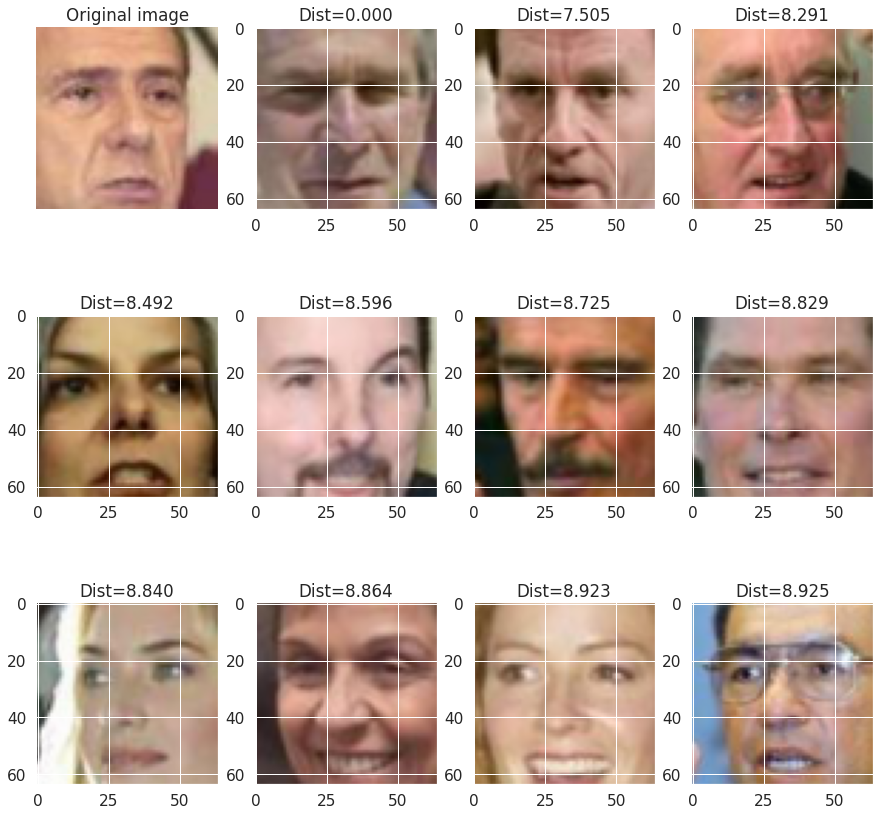

In [63]:
show_similar(fvae, data_train, data_train[rand_idx])